In [1]:
# https://github.com/craigmacartney/Spark-ALS-Recommendation/blob/master/AmazonRecommendationSystem.ipynb

In [59]:
# import packages 
import sys
import pandas as pd
import seaborn as sns
from time import time
from pyspark.sql import Row
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit,CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml import Pipeline, PipelineModel

%matplotlib inline

In [2]:

# check env
!printenv|egrep "SPARK_HOME|PYSPARK_PYTHON|PYSPARK_DRIVER_PYTHON"

PYSPARK_DRIVER_PYTHON=jupyter
PYSPARK_PYTHON=python
PYSPARK_DRIVER_PYTHON_OPTS=notebook
SPARK_HOME=/home/spark/spark-2.4.5-bin-hadoop2.7


In [3]:
# create a spark session
spark = SparkSession.builder.getOrCreate()

# spark and python version
print(spark.version)
print(sys.version)

2.4.5
3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]


In [4]:
# dataset path
df_raw = spark.read.csv("hdfs://devenv/user/spark/whisky/user_whisky_score.csv",header = True)
                     #video_games = './reviews_Video_Games_5.json'
df_raw = df_raw.withColumn("rating", df_raw["score"].cast("float")).drop(df_raw["score"])

# Show first two rows and display number of rows
df_raw.show(n=2)
df_raw.count()
df_raw.printSchema()
df_raw.describe().show()

+-----------------+--------------------+------+
|        user_name|         whisky_name|rating|
+-----------------+--------------------+------+
|      bignocowski|caol-ila-2004-con...|   4.0|
|Dreaming-of-Islay|caol-ila-2004-con...|   4.0|
+-----------------+--------------------+------+
only showing top 2 rows

root
 |-- user_name: string (nullable = true)
 |-- whisky_name: string (nullable = true)
 |-- rating: float (nullable = true)

+-------+--------------------+--------------------+------------------+
|summary|           user_name|         whisky_name|            rating|
+-------+--------------------+--------------------+------------------+
|  count|              398755|              398755|            398755|
|   mean|   7243811.646959459|              1792.0|3.7555660744065906|
| stddev|1.3272575095428279E8|                 0.0|0.8704320845232698|
|    min|              #NAME?|10th-mountain-bou...|              0.25|
|    max|             zzwicky|zuidam-millstone-...|            

# Preprocessing
Spark ALS requires user and items to be in numeric form, so we have to transform the alpha-numeric user and asins into unique ids first

In [5]:

# transform user_name and whisky_name string to index using spark StringIndexer function

whiskyIndexer = StringIndexer(inputCol="whisky_name", outputCol="item",handleInvalid='error') # create indexer for asins
userIndexer = StringIndexer(inputCol='user_name',outputCol='userid',handleInvalid='error') # create indexer for user

whiskyIndexed = whiskyIndexer.fit(df_raw).transform(df_raw) # apply whisky_name indexer
userIndexed = userIndexer.fit(whiskyIndexed).transform(whiskyIndexed) # apply user indexer


df_indexed = userIndexed.drop('whisky_name').drop('user_name') # remove old columns with alphanumeric strings
df_indexed.show()

+------+------+-------+
|rating|  item| userid|
+------+------+-------+
|   4.0|3358.0| 9674.0|
|   4.0|3358.0|   39.0|
|  2.25|3358.0|43904.0|
|  4.25|3358.0|  636.0|
|  3.75|3358.0|35629.0|
|   3.5|3358.0|10093.0|
|   3.0|3358.0|16529.0|
|   4.0|3358.0|    2.0|
|   4.0|3358.0| 2231.0|
|   4.0|3358.0|  947.0|
|   4.0|3358.0|  177.0|
|   4.5|5275.0|12118.0|
|  4.75|5275.0|35081.0|
|  4.25|5275.0| 4406.0|
|   5.0|5275.0|  326.0|
|   3.0|3307.0| 1136.0|
|   3.0|3307.0|10353.0|
|  4.25|3307.0|20295.0|
|   4.0|3307.0|  322.0|
|  3.75|3307.0| 2206.0|
+------+------+-------+
only showing top 20 rows



In [6]:
# 70-30 train-test split
(df_train, df_test) = df_indexed.randomSplit([0.7,0.3])

# cache them in memory across clusters since we access this data frequently 
df_train.cache() 
df_test.cache()
# Display dataset size
print('Train set size: {}'.format(df_train.count()))
print('Test set size: {}'.format(df_test.count()))

Train set size: 278492
Test set size: 120263


In [7]:
df_train.show()
df_test
df_test.printSchema()

+------+-----+-------+
|rating| item| userid|
+------+-----+-------+
|  0.25|  4.0|  102.0|
|  0.25| 24.0|  645.0|
|  0.25| 34.0| 8262.0|
|  0.25| 67.0|10305.0|
|  0.25| 88.0|   20.0|
|  0.25| 95.0| 3370.0|
|  0.25|108.0|    5.0|
|  0.25|119.0|  285.0|
|  0.25|119.0| 1731.0|
|  0.25|119.0| 3613.0|
|  0.25|119.0|71140.0|
|  0.25|184.0|   27.0|
|  0.25|184.0|  367.0|
|  0.25|184.0| 1407.0|
|  0.25|184.0| 1804.0|
|  0.25|184.0| 2636.0|
|  0.25|184.0|18299.0|
|  0.25|184.0|70467.0|
|  0.25|194.0|20298.0|
|  0.25|196.0|24515.0|
+------+-----+-------+
only showing top 20 rows

root
 |-- rating: float (nullable = true)
 |-- item: double (nullable = false)
 |-- userid: double (nullable = false)



In [8]:
print('Matrix size, percentage of matrix filled and number of distinct users and itmes:')
# calculate percentage of the user-item matrix that is filled
df_train.createOrReplaceTempView('df_train')
spark.sql("""
      SELECT *, 100 * rating/matrix_size AS percentage
        FROM (
          SELECT userid, item, rating, userid * item AS matrix_size
            FROM(
              SELECT COUNT(*) AS rating, COUNT(DISTINCT(item)) AS item, COUNT(DISTINCT(userid)) AS userid
                FROM df_train
                )
            )
""").show()

Matrix size, percentage of matrix filled and number of distinct users and itmes:
+------+----+------+-----------+-------------------+
|userid|item|rating|matrix_size|         percentage|
+------+----+------+-----------+-------------------+
| 61970|8373|278492|  518874810|0.05367229139529822|
+------+----+------+-----------+-------------------+



# Visualization

In [9]:
df_viz = df_indexed.sample(False,0.09) # sample a small portion of the dataset for visualization
pdf = df_viz.toPandas() # convert to pandas dataframe
# pdf

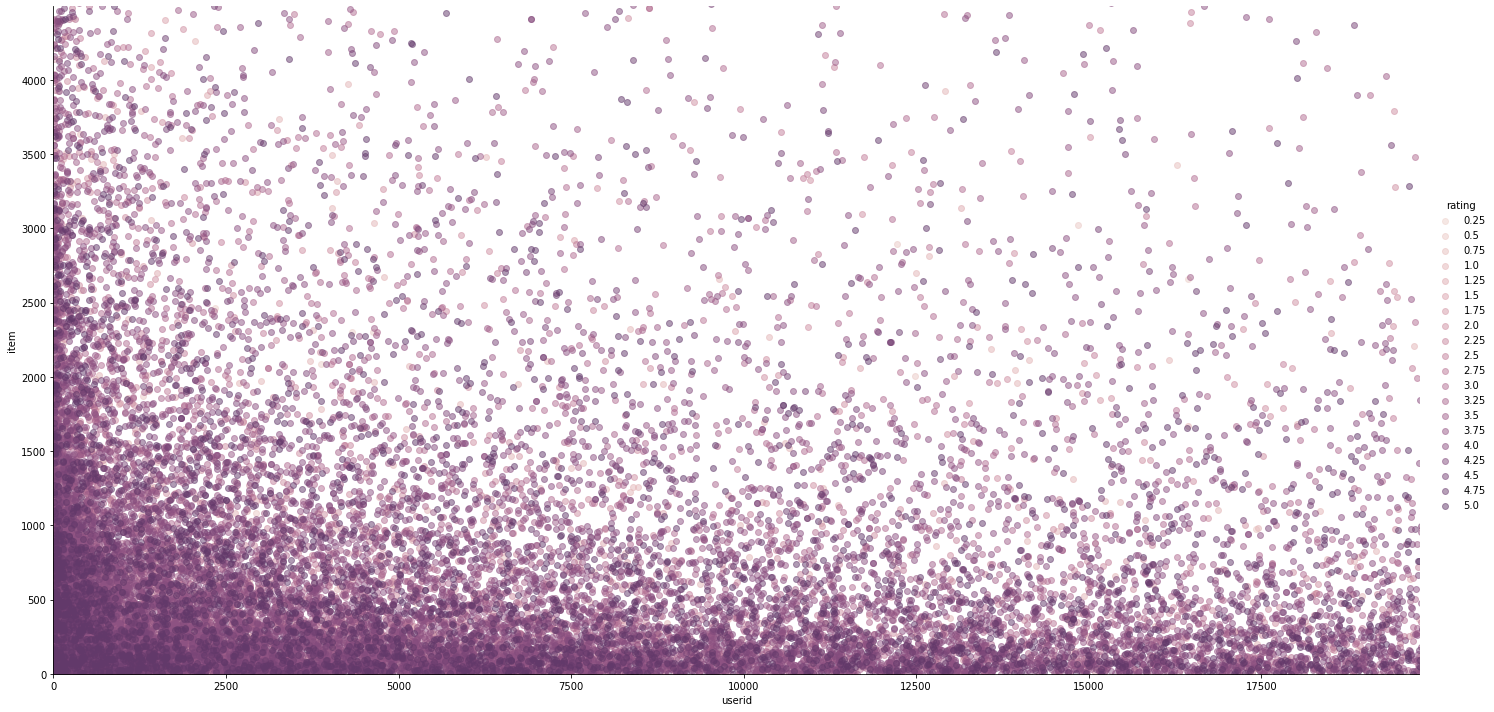

In [10]:
numuniquser = pdf['userid'].value_counts().count() # to set axis
numuniqitem = pdf['item'].value_counts().count() # to set axis
custompal = sns.cubehelix_palette(25)
# custompal = sns.xkcd_palette(['red', 'orange', 'sandy yellow', 'yellowgreen', 'vibrant green']) # traffic-light style palette
scplot = sns.lmplot('userid','item',pdf,hue='rating',fit_reg=False,height=10 # use seaborn lmplot to plot user vs item and rating as hue
           , aspect=2,palette=custompal,scatter_kws={'alpha':0.5})


axes = scplot.axes
axes[0,0].set_ylim(0,numuniqitem)  
axes[0,0].set_xlim(0,numuniquser) 
scplot
plt.savefig('scatterplot.png',dpi=50)



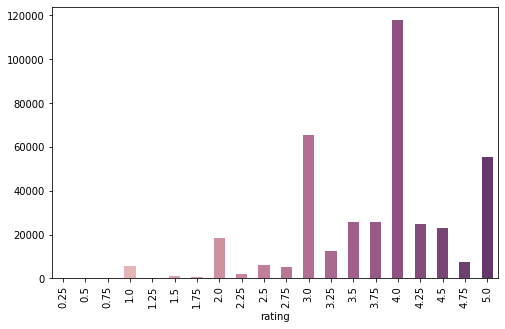

In [11]:
df_indexed.createOrReplaceTempView('df_ind') # create temp SQL view

# count number of ratings in each category 
ratingcount = spark.sql("""
      SELECT COUNT(rating) as count
      ,rating
      FROM df_ind
      GROUP BY rating
""")
pandas_rc = ratingcount.toPandas()  # convert to pandas
pandas_rc.sort_values('rating',axis=0,inplace=True) # sort 
pandas_rc.plot(x='rating',y='count',kind='bar',legend=False,color=custompal,figsize=(8,5)) # plot using the traffic-light palette
plt.savefig('barchart.png',dpi=70) # save to disk
plt.show()

In [12]:
pandas_rc

,count,rating
2,327,0.25
9,383,0.50
4,197,0.75
13,5787,1.00
17,325,1.25
7,1132,1.50
10,814,1.75
3,18407,2.00
14,2017,2.25
1,6029,2.50


# Baseline

In [13]:
mean = float(df_train.describe().toPandas()['rating'][1]) # mean
print('Training set mean: {}'.format(mean))
print('Test set baseline MSE and RMSE')  
se_rdd = df_test.rdd.map(lambda x: (x[0]-mean)**2) #  squared error
# se_rdd.take(50)
row = Row("val") # create row
se_df = se_rdd.map(row).toDF() # convert to df
# se_df.show()
se_df.createOrReplaceTempView('se_df') # create temp SQL view
baseline = spark.sql('SELECT AVG(val) as MSE,SQRT(AVG(val)) as RMSE  FROM se_df') # calculate MSE and RMSE
baseline.show()
baseline_rmse = float(baseline.toPandas()['RMSE'][0])

Training set mean: 3.756178813035922
Test set baseline MSE and RMSE
+------------------+------------------+
|               MSE|              RMSE|
+------------------+------------------+
|0.7569180920347395|0.8700103976589817|
+------------------+------------------+



# ALS
Define Pipeline

In [19]:

# define overall pipeline 

def als_pipeline(df_train,df_test,trainingdownsampling=0.99):
    """
      Args: 
        df_train: pyspark train dataframe  
        df_test: pyspark test dataframe
        trainingdownsampling: percentage of full training set
      Returns:
        testset_rmse
        baseline_rmse
        wallclock
    """
#     trainingdownsampling=0.99
    # model
    als = ALS(userCol="userid", itemCol="item", ratingCol="rating",coldStartStrategy='drop',nonnegative=False)

    # # evaluator
    rmseevaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")


    # # # parameter grid
    paramGrid = ParamGridBuilder()\
        .addGrid(als.rank, [1, 5, 10,50,70]) \
        .addGrid(als.maxIter, [15])\
        .addGrid(als.regParam, [0.05, 0.1, 0.5,5])\
        .build()
    paramGrid
    # # train validation split
    tvs = TrainValidationSplit(estimator=als,
                               estimatorParamMaps=paramGrid,
                               evaluator=rmseevaluator,
                               trainRatio=0.8)
   

    # # sample, Note : spark sample does is not guaranteed to provide exactly the fraction specified of the total
    training = df_train.sample(False,trainingdownsampling)
    print('Full training set size: {}'.format(df_train.count()))
    print('Downsampled training set size: {} \n'.format(training.count()))

    # # fit model and time it
    print('Fitting model...')
    startTime = time()
    tvsmodel = tvs.fit(training) #訓練模型
    tvsmodel.write().overwrite().save('hdfs://devenv/user/spark/whisky/AlSmodel')  #savemodel
    
    endTime = time()
    wallclock = ( endTime - startTime )

    print('Wall-clock time: {}'.format(wallclock))

    print('\n')
    paramMap = list(zip(tvsmodel.validationMetrics,tvsmodel.getEstimatorParamMaps())) # zip validation rmse and selected parameters
    paramMax = min(paramMap)
    print('Best parameters and validation set RMSE:')
    print(paramMax)
    print('\n')

    # predict and evaluate test set
    predictions = tvsmodel.transform(df_test)
    testset_rmse = rmseevaluator.evaluate(predictions)
    print('Test set RMSE: {}'.format(testset_rmse))    
    return testset_rmse,wallclock,paramMax



# ALS on downsampled training sets¶
Run the pipeline for a set of downsampling percentages

In [20]:
downsamples = [0.01,0.1,0.5,0.8] # list of percentages to downsample training set
rmses = [] 
wallclocks = []
params = []
# loop through the list and apply the pipeline function, append the results to the above empty lists
for s in downsamples:
    print('Fitting als model for {} % of the training set'.format(s*100))
    test_rmse,wallclock,parammax = als_pipeline(df_train,df_test,trainingdownsampling=s)
    rmses.append(test_rmse)
    wallclocks.append(wallclock)
    params.append(parammax)

Fitting als model for 1.0 % of the training set
Full training set size: 278492
Downsampled training set size: 2816 

Fitting model...
Wall-clock time: 215.03596997261047


Best parameters and validation set RMSE:
(3.810899882260969, {Param(parent='ALS_b748a54600f7', name='rank', doc='rank of the factorization'): 50, Param(parent='ALS_b748a54600f7', name='maxIter', doc='max number of iterations (>= 0).'): 15, Param(parent='ALS_b748a54600f7', name='regParam', doc='regularization parameter (>= 0).'): 0.5})


Test set RMSE: 3.7959072769058073
Fitting als model for 10.0 % of the training set
Full training set size: 278492
Downsampled training set size: 28095 

Fitting model...
Wall-clock time: 266.52400851249695


Best parameters and validation set RMSE:
(1.642925724382148, {Param(parent='ALS_67753148c3d9', name='rank', doc='rank of the factorization'): 70, Param(parent='ALS_67753148c3d9', name='maxIter', doc='max number of iterations (>= 0).'): 15, Param(parent='ALS_67753148c3d9', name='re

# ALS on the full training set

In [22]:
 # model
als = ALS(userCol="userid", itemCol="item", ratingCol="rating",coldStartStrategy='drop',nonnegative=False)


# evaluator
rmseevaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# parameter grid
paramGrid = ParamGridBuilder()\
    .addGrid(als.rank, [1, 5, 10,50,70]) \
    .addGrid(als.maxIter, [15])\
    .addGrid(als.regParam, [0.05, 0.1, 0.5,5])\
    .build()

# train validation split
tvs = TrainValidationSplit(estimator=als,
                           estimatorParamMaps=paramGrid,
                           evaluator=rmseevaluator,
                           trainRatio=0.8)
# fit model and time
startTime = time()
tvsmodel = tvs.fit(df_train)
endTime = time()
wallclock = ( endTime - startTime )
    
print('Wall-clock time: {}'.format(wallclock))
    
print('\n')
# zip train validation and parameter into one list
paramMap = list(zip(tvsmodel.validationMetrics,tvsmodel.getEstimatorParamMaps()))
paramMax = min(paramMap)
print(paramMax)

# predict and evaluate test set
predictions = tvsmodel.transform(df_test)
testset_rmse = rmseevaluator.evaluate(predictions)
print('Test set RMSE: {}'.format(testset_rmse))

Wall-clock time: 441.70310854911804


(0.887178396617003, {Param(parent='ALS_1103d4062de1', name='rank', doc='rank of the factorization'): 50, Param(parent='ALS_1103d4062de1', name='maxIter', doc='max number of iterations (>= 0).'): 15, Param(parent='ALS_1103d4062de1', name='regParam', doc='regularization parameter (>= 0).'): 0.1})
Test set RMSE: 0.8555388783098729


# Collecting Results


In [23]:
# append with full train set
rmses.append(testset_rmse)
wallclocks.append(wallclock)
params.append(paramMax)



In [24]:
# getting terms separately since dictionaries are only ordered in Python 3.6 onwards, we are still on Python 3.5
rank1 = list(params[0][1].values())[0]
iter1 = list(params[0][1].values())[1]
reg1 = list(params[0][1].values())[2]

rank2 = list(params[1][1].values())[1]
iter2 = list(params[1][1].values())[2]
reg2 = list(params[1][1].values())[0]

rank3 = list(params[2][1].values())[0]
iter3 = list(params[2][1].values())[2]
reg3 = list(params[2][1].values())[1]

rank4 = list(params[3][1].values())[1]
iter4 = list(params[3][1].values())[0]
reg4 = list(params[3][1].values())[2]

rank5 = list(params[4][1].values())[0]
iter5 = list(params[4][1].values())[1]
reg5 = list(params[4][1].values())[2]

In [25]:
# convert to lists
val_rmse = list(map(lambda x: x[0], params))
ranks = [rank1,rank2,rank3,rank4,rank5]
iters = [iter1,iter2,iter3,iter4,iter5]
regParams = [reg1,reg2,reg3,reg4,reg5]
downsamples.append(1)

In [26]:
pd_results = pd.DataFrame(
    {'Downsample percentage': downsamples,
     'Number of latent factors': ranks,
     'Maximum number of iterations': iters,
     'Regularization parameter': regParams,
     'Wall-clock time': wallclocks,
     'Validation RMSE': val_rmse,
     'Test RMSE': rmses
    })

In [27]:
# display dataframe
pd_results

,Downsample percentage,Number of latent factors,Maximum number of iterations,Regularization parameter,Wall-clock time,Validation RMSE,Test RMSE
0,0.01,50,15.0,0.5,215.035970,3.810900,3.795907
1,0.10,15,0.5,70.0,266.524009,1.642926,1.390832
2,0.50,50,0.5,15.0,363.323581,0.966126,0.951031
3,0.80,15,70.0,0.1,422.813667,0.918061,0.888203
4,1.00,50,15.0,0.1,441.703109,0.887178,0.855539


In [28]:
# save to disk
pd_results.to_csv('results.csv')

# Visualizing Results

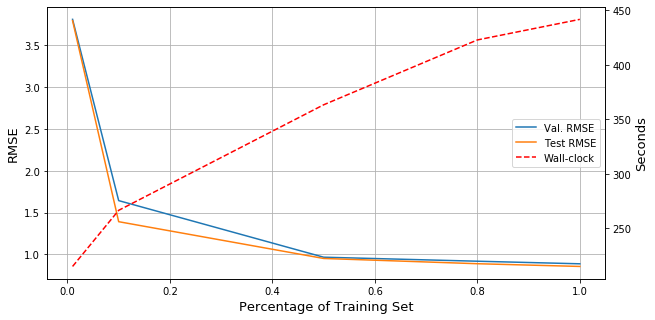

In [29]:
fig, ax1 = plt.subplots(figsize=(10,5))
x = pd_results['Downsample percentage']
y1 = pd_results['Validation RMSE']
y2 = pd_results['Test RMSE']
line1 = ax1.plot(x,y1,label= 'Val. RMSE')
line2 = ax1.plot(x,y2,label= 'Test RMSE')
ax2 = ax1.twinx()
y3 = pd_results['Wall-clock time']
line3 = ax2.plot(x,y3,'r--',label='Wall-clock')
# labeling

ys = line1+line2+line3
labels = [l.get_label() for l in ys]
ax1.legend(ys, labels, loc='center right')

ax1.grid()
ax1.set_xlabel('Percentage of Training Set',fontsize=13)
ax1.set_ylabel('RMSE',fontsize=13)
ax2.set_ylabel('Seconds',fontsize=13)
plt.savefig('results.png',dpi=70)
plt.show()


# Recommend whisky

TrainValidationSplitModel_4750f7ac1c4b

In [83]:
from pyspark.sql.functions import lit
from pyspark.ml.feature import IndexToString

def recommendwhiskys(model, user, num_rec):
    # Create a dataset with distinct whisky as one column and the user of interest as another column
    itemsuser = df_train.select("item").distinct().withColumn("userid", lit(user))
#     itemsuser.show(n=3)

    # filter out games that user has already rated 
    whiskysrated = df_train.filter(df_train.userid == user).select("item", "userid")

    # apply trained recommender system
    predictions = model.transform(itemsuser.subtract(whiskysrated)).dropna().orderBy("prediction", ascending=False).limit(num_rec).select("item", "prediction")
#     predictions.show()
    
    # convert index back to original whisky 
    converter = IndexToString(inputCol="item", outputCol="recommend_whisky")
    converted = converter.transform(predictions)
#     converted.show()
    convertedtordd = converted.rdd.take(num_rec)
    for item in convertedtordd:
        
        print("推薦whisky:{}, 推薦評分:{}".format(str(item[2]),item[1]))

In [84]:
recommendwhiskys(tvsmodel,696,3)

推薦whisky:bruichladdich-micro-provance, 推薦評分:4.740784168243408
推薦whisky:nikka-single-cask-malt-whisky, 推薦評分:4.682675838470459
推薦whisky:single-cask-nation-ledaig-13, 推薦評分:4.654045104980469


In [82]:
if __name__ == "__main__":
    print("==========載入模型==============")
    
    from pyspark.ml.tuning import TrainValidationSplitModel
    model = TrainValidationSplitModel.load("hdfs://devenv/user/spark/whisky/AlSmodel")
   
    print("==========進行推薦===============")
    print("=========輸入推薦項目數量==============")
    productnum=int(input())
    print("=========輸入使用者id==============")
    usernum = int(input())
    recommendwhiskys(model,usernum,productnum)
        

==========載入模型==============
==========進行推薦===============
=========輸入推薦項目數量==============
25
=========輸入使用者id==============
3
推薦whisky:chichibu-the-single-cask-peated, 推薦評分:4.360744953155518
推薦whisky:lagavulin-feis-ile-2013, 推薦評分:4.270208358764648
推薦whisky:st-magdalene-1975-rare-old-gordon-and-macphail, 推薦評分:4.249618053436279
推薦whisky:benriach-38-year-1977-cask-3111, 推薦評分:4.249618053436279
推薦whisky:glenfiddich-snow-phoenix, 推薦評分:4.228520393371582
